<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import re
import pickle
import random
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

warnings.simplefilter('ignore')
plt.style.use('dark_background')

%matplotlib inline

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">

Сиды нужны для фиксации псевдослучайного состояния, которое необходимо для получения одних и тех же результатов на разынх устройствах в случае работы над кодом разных разработчиков, а также для отладки кода и сравнения моделей, чтобы результаты при разбиении данных получались одни и те же. Иначе получится так, что разные модели могут обучаться на разных наборах данных и таким образом не понятно будет, что повлияло на результат. Так же рекомендуется не просто фиксировать сид с помощью random.seed(42) и np.random.seed(42), а прописывать переменную RANDOM_STATE=42 и уже ее использовать при предобработке, разбиении данных или в обучении моделей, т.к. не все библиотеки под капотом используют random или numpy и фиксация сида без использования переменной может не сработать, поэтому лучше сразу привыкать к использованию переменной.

</div>

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [3]:
df_train.to_csv("cars_test.csv", index=False)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [5]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


In [6]:
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [7]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0


In [8]:
def show_null(df: pd.DataFrame):
    nulls = pd.Series(df.isna().sum())
    print('Признаки с пропусками')
    print(nulls[nulls != 0])

In [9]:
def show_duplicates(df: pd.DataFrame):
    print('Количество дубликатов')
    print(df.duplicated().sum())

In [10]:
show_null(df_train)

Признаки с пропусками
mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64


In [11]:
show_null(df_test)

Признаки с пропусками
mileage      19
engine       19
max_power    19
torque       19
seats        19
dtype: int64


In [12]:
show_duplicates(df_train)

Количество дубликатов
985


In [13]:
show_duplicates(df_test)

Количество дубликатов
62


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">

В данных имеются пропуски в таких столбцах, как mileage, engine, max_power, torque, seats. Также в трейне и тесте есть полные дубликаты.

</div>

In [14]:
ProfileReport(df_train, title="Profiling Report df_train").to_file("df_train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 163.36it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
ProfileReport(df_test, title="Profiling Report df_test").to_file("df_test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 22967.97it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">

При сравнении трейна и теста видно, что практически все признаки имеют похожие распределения, кроме km_driven, у него есть большие выбросы в трейне, которых нет в тесте, за счет чего получается длинный хвост вправо. Также есть различия в max_power. Он в тесте имеет тип данных object в отличии от трейна за счет наличия в значениях текста bhp, который надо будет убирать, чтобы получить числовые занчения. Если посмотреть на корреляцию, то она выглядит вполне адекватно, есть заметная прямая связь целевой переменной и годом выпуска (более молодые авто стоят дороже), мощностью (чем больше мощность, тем дороже) и обратная с километражем (чем больше ездит, тем дешевле).

</div>

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        981 non-null    object 
 9   engine         981 non-null    object 
 10  max_power      981 non-null    object 
 11  torque         981 non-null    object 
 12  seats          981 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 101.7+ KB


In [18]:
df_train.select_dtypes(include=np.number).describe()

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [19]:
df_test.select_dtypes(include=np.number).describe()

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


In [20]:
df_train.select_dtypes(include='object').describe()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803.0,6796
unique,1924,4,3,2,5,386,120,313.0,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74.0,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330.0,468


In [21]:
df_test.select_dtypes(include='object').describe()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">

В числовых признаках медиана и среднее очень похожи между трейном и тестом, что на первый взгляд говорит, что выборки пренадлежат одной генеральной совокупности. В km_driven	есть сильные выбросы, которых не наблюается в тесте.
В категориальных признаках много уникальных значений у mileage,	engine, max_power, torque, в такой ситуации нужно будет применить преобразование. Признаки fuel,	seller_type,	transmission,	owner	имеют одинаковые топовые значения, это еще один признак похожести выборок.

</div>

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [22]:
show_duplicates(df_train.drop('selling_price', axis=1))

Количество дубликатов
1159


In [23]:
df_train[df_train.drop('selling_price', axis=1).duplicated(keep=False)].sort_values(df_train.drop('selling_price', axis=1).columns.tolist())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1703,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33,380Nm@ 1750-2500rpm,5.0
6307,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33,380Nm@ 1750-2500rpm,5.0
1836,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4,580Nm@ 1400-3250rpm,5.0
6704,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4,580Nm@ 1400-3250rpm,5.0
117,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5637,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190.0,400Nm,5.0
5652,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190.0,400Nm,5.0
5753,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190.0,400Nm,5.0
5991,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190.0,400Nm,5.0


In [24]:
df_train = df_train.drop_duplicates(subset=df_train.drop('selling_price', axis=1).columns).reset_index(drop=True)

In [25]:
df_train.shape

(5840, 13)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Для разных рынков производители называют модели авто по разному. Есть вероятность, что некоторые модели могут иметь одинаковые признаки и разные названия. Проверим.
</div>

In [26]:
df_train[df_train.drop(['selling_price', 'name'], axis=1).duplicated(keep=False)].sort_values(df_train.drop(['selling_price', 'name'], axis=1).columns.tolist())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
69,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
4122,Tata Indica DLX,2003,40000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
4127,Hyundai Santro DX,2003,55000,120000,Petrol,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
5395,Hyundai Accent Gvs,2003,70000,120000,Petrol,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
1011,Hyundai Santro GS zipDrive - Euro II,2004,60000,120000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,Hyundai Santro Era,2019,420000,30000,Petrol,Individual,Manual,First Owner,20.3 kmpl,1086 CC,68.0,99Nm@ 4500rpm,5.0
4104,Maruti Swift VXI,2020,570000,5000,Petrol,Individual,Manual,First Owner,21.21 kmpl,1197 CC,81.8,113Nm@ 4200rpm,5.0
4433,Maruti Swift ZXI Plus,2020,578000,5000,Petrol,Individual,Manual,First Owner,21.21 kmpl,1197 CC,81.8,113Nm@ 4200rpm,5.0
2485,Maruti Alto 800 LXI,2020,350000,5000,Petrol,Individual,Manual,First Owner,22.05 kmpl,796 CC,47.3,69Nm@ 3500rpm,5.0


In [27]:
df_train.shape

(5840, 13)

In [28]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [29]:
def convert_cat_col_to_num(df: pd.DataFrame) -> pd.DataFrame:
    cols = ['mileage', 'engine', 'max_power']
    for col in cols:
      df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='raise').astype(float)

    # функция доработана при помощи deepseek
    def extract_simple(torque_str):
        if pd.isna(torque_str):
            return pd.Series([np.nan, np.nan])

        s = str(torque_str).lower()
        s = s.replace(',', '')
        s = re.sub(r'[()]', ' ', s)

        # Извлекаем все числа
        numbers = re.findall(r'\d+\.?\d*', s)
        numbers = [float(x) for x in numbers]

        # Извлекаем единицы измерения - ищем в исходной строке ДО очистки
        has_kgm = 'kgm' in s
        has_nm = 'nm' in s or ('n' in s and 'm' in s and 'kgm' not in s)

        torque_value = np.nan
        max_rpm = np.nan

        if numbers:
            # Первое число - обычно значение момента
            torque_value = numbers[0]
            if has_kgm:
                torque_value *= 9.807

            # Ищем RPM (обычно последнее число или из диапазона)
            if len(numbers) >= 2:
                if 'rpm' in s:
                    # Находим ВСЕ числа перед RPM
                    parts_before_rpm = s.split('rpm')[0]
                    rpm_numbers = re.findall(r'\d+\.?\d*', parts_before_rpm)
                    if rpm_numbers:
                        rpm_numbers = [float(x) for x in rpm_numbers]
                        # Ищем числа, которые могут быть оборотами (обычно > 1000)
                        potential_rpm = [x for x in rpm_numbers if x > 500]
                        if potential_rpm:
                            max_rpm = max(potential_rpm)

                # Если RPM не найдены, но есть несколько чисел
                if pd.isna(max_rpm):
                    # Ищем числа, которые могут быть оборотами (исключаем значение момента)
                    potential_rpm = [x for x in numbers[1:] if x > 500 and x <= 10000]
                    if potential_rpm:
                        max_rpm = max(potential_rpm)
                    else:
                        # Берем последнее число как запасной вариант
                        max_rpm = numbers[-1]

        return pd.Series([torque_value, max_rpm])

    df[['torque', 'max_torque_rpm']] = df['torque'].apply(extract_simple)

    return df

In [30]:
df_train = convert_cat_col_to_num(df_train)
df_train.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.0000,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.0000,5.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,219.6768,5.0,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,112.7805,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.7500,5.0,4000.0
5,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.30,1061.0,57.50,76.4946,5.0,4500.0
6,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,16.10,796.0,37.00,59.0000,4.0,2500.0
7,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59,1364.0,67.10,170.0000,5.0,2400.0
8,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,20.00,1399.0,68.10,160.0000,5.0,2000.0
9,Renault Duster 110PS Diesel RxL,2014,500000,68000,Diesel,Individual,Manual,Second Owner,19.01,1461.0,108.45,248.0000,5.0,2250.0


In [31]:
df_test = convert_cat_col_to_num(df_test)
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498.0,112.0,260.0,7.0,2200.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497.0,108.5,260.0,5.0,2750.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799.0,130.0,172.0,5.0,4300.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498.0,98.6,200.0,5.0,1750.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172.0,65.0,96.0,5.0,3000.0


### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [32]:
num_cols = df_train.select_dtypes(include=np.number).columns
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_test[num_cols] = df_test[num_cols].fillna(df_train[num_cols].median())

In [33]:
show_null(df_train)

Признаки с пропусками
Series([], dtype: int64)


In [34]:
show_null(df_test)

Признаки с пропусками
Series([], dtype: int64)


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
В данных есть выбросы, а среднее чувствительно к ним, поэтому лучше в такой ситуации применить медиану. Для тренировочной и тестовой выборки применяется медиана от тренировочной, чтобы избежать утечки данных, а также в будущей выборке могут прийти данные с пропусками в этих признаках и мы будем заполнять их медианой из тех данных, которые у нас уже были в тренировочной выборке.
</div>

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [35]:
df_train[['engine', 'seats']] = df_train[['engine', 'seats']].astype(int)
df_test[['engine', 'seats']] = df_test[['engine', 'seats']].astype(int)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Seats возможно рассмотреть как категориальную фичу, потому что это дискретная величина, так еще и ограниченная сверху и снизу.
</div>

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [36]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.430841,1429.448973,87.892354,175.931047,5.426712,3045.789041
std,4.095622,5.354320e+05,6.007114e+04,3.985973,485.662834,31.661223,116.759887,0.982344,911.039323
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,47.073600,2.000000,1400.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,111.800000,5.000000,2250.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.370000,1248.000000,81.860000,160.000000,5.000000,3000.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,200.062800,5.000000,4000.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,3726.660000,14.000000,21800.000000


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Все признаки, в которых мы заполняли пропуски, кроме seats, были категориальными при первом запуске describe. Если рассмотреть seats, то у этого признака практически ничего не поменялось. Если смотреть в общем и целом заполнение медианой не затронит только медиану в случае не идеального нормального распределения, т.к. заполнение медианой, в случае если медиана отличается от среднего, повлечет за собой изменение среднего, а оно повлечет измение дисперсии и стандартного отклонения.
</div>



## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

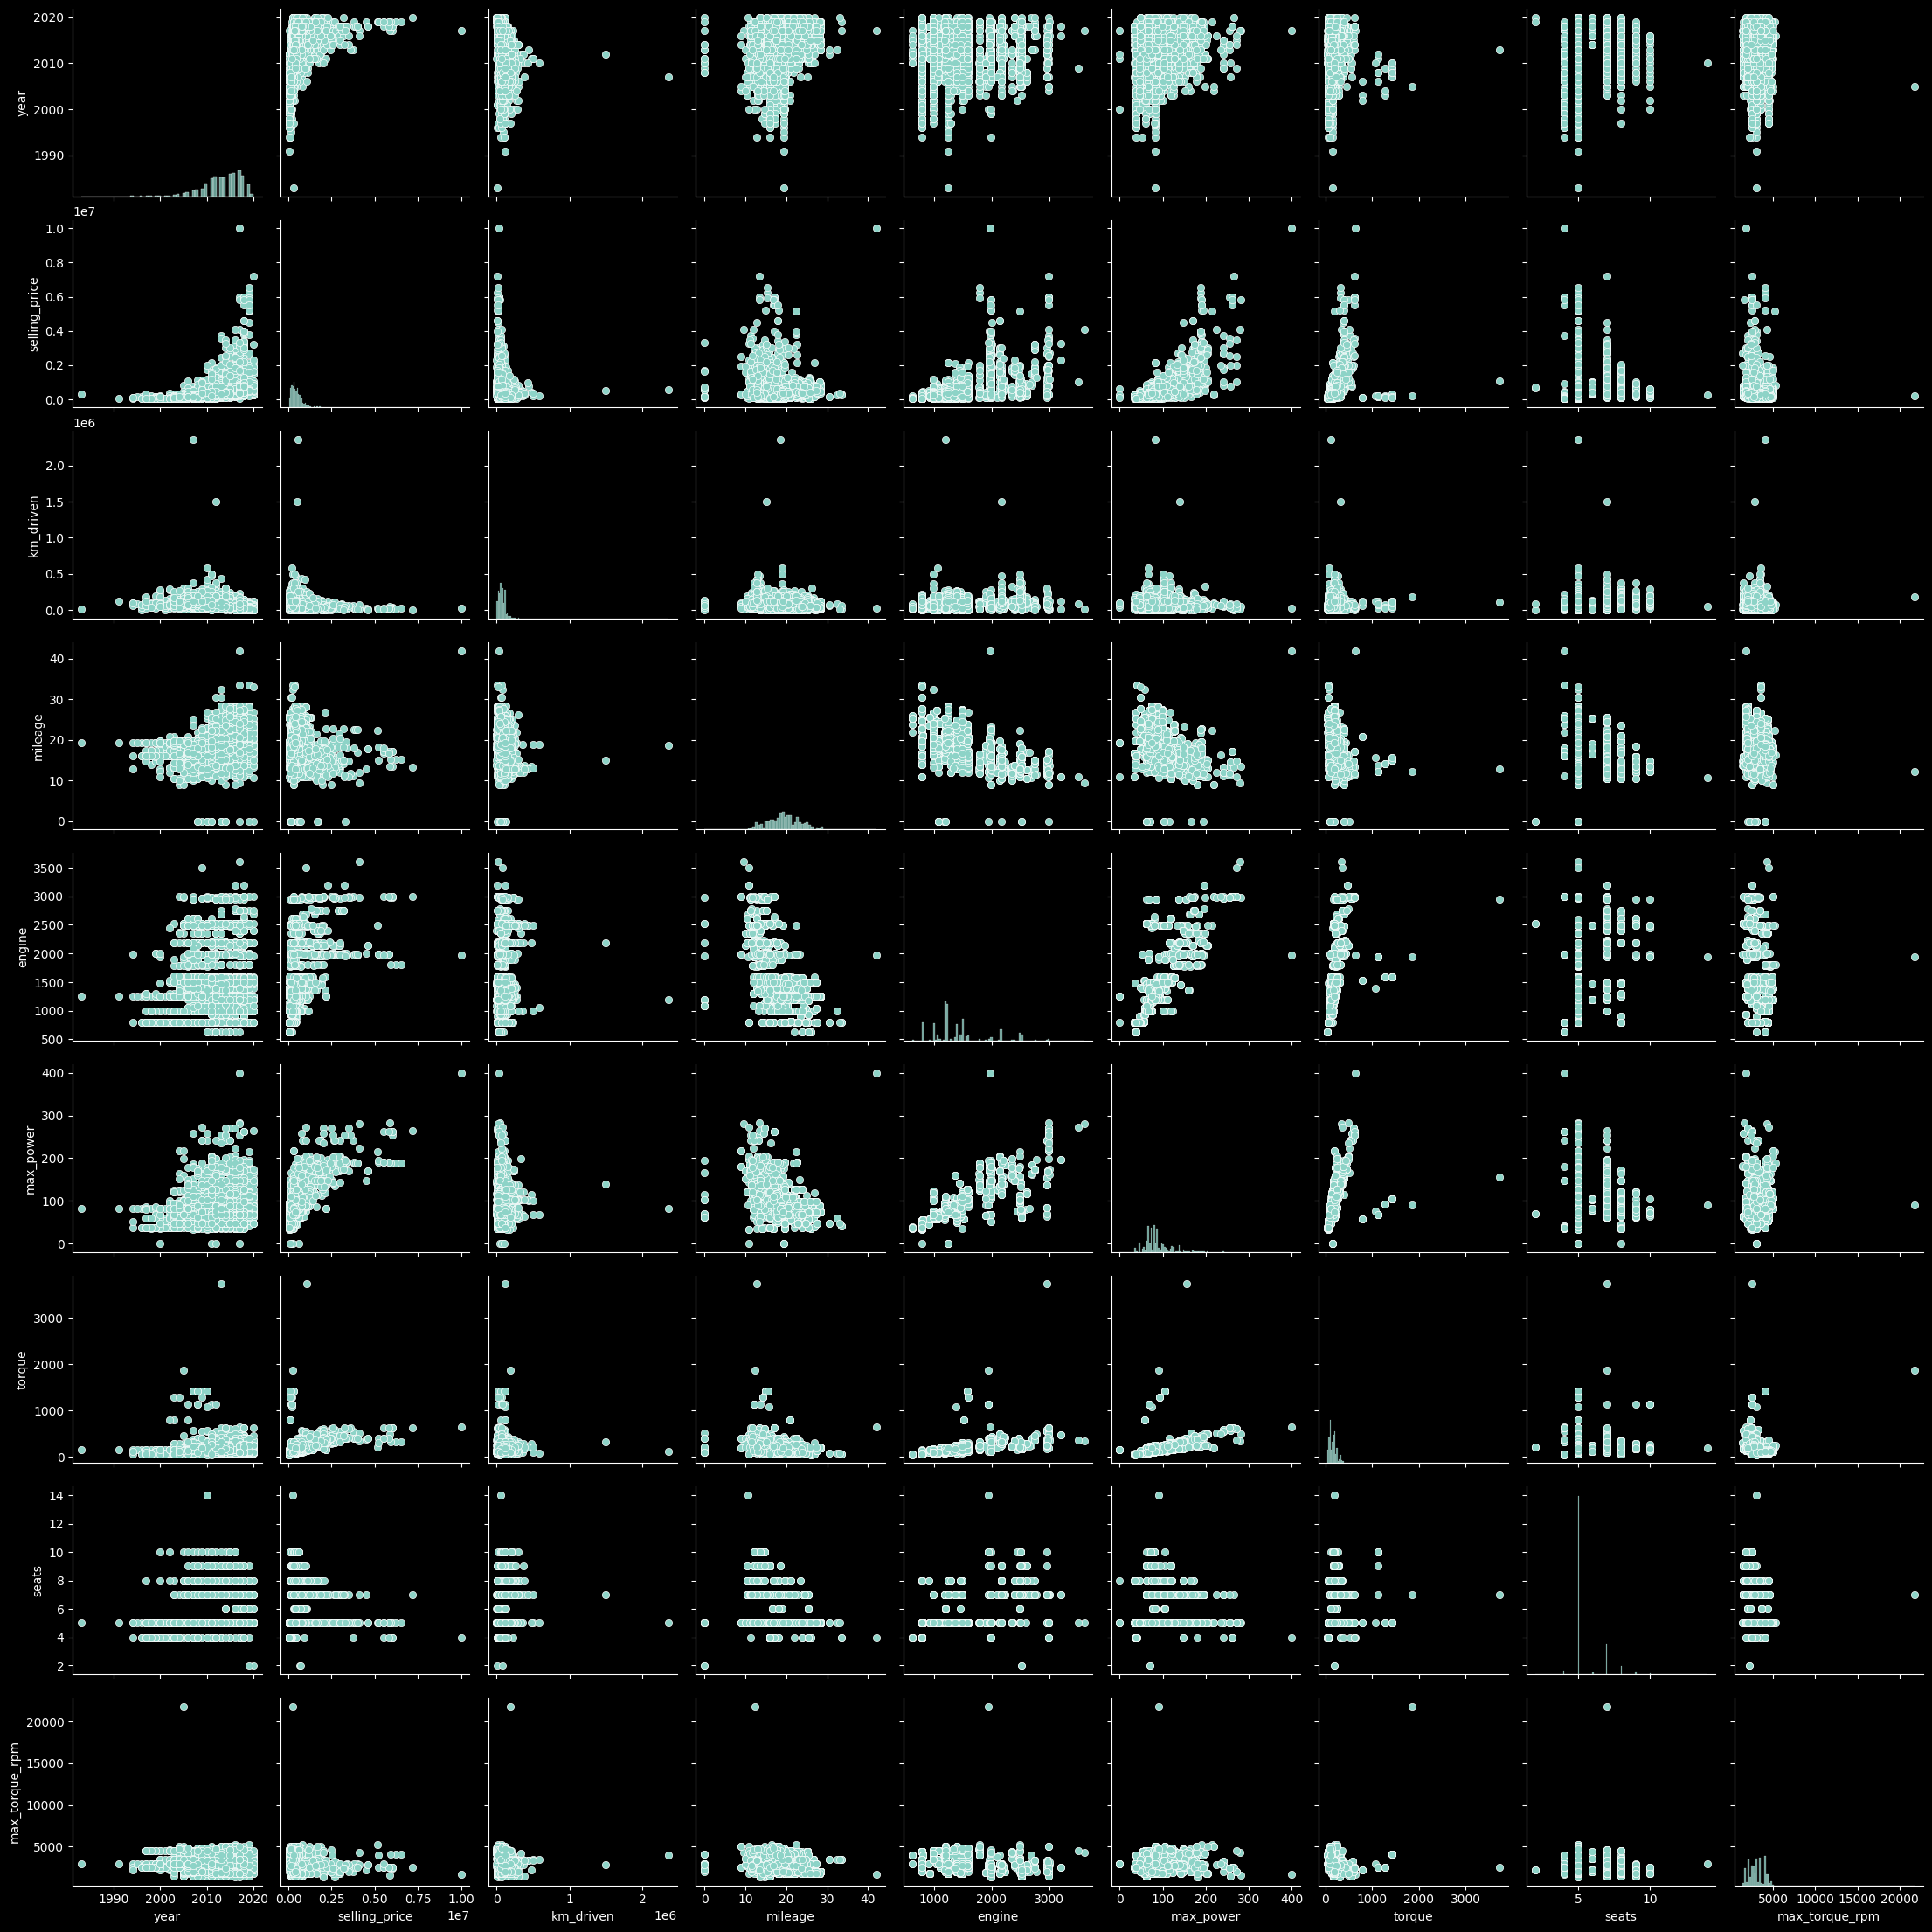

In [37]:
sns.pairplot(df_train[num_cols]);

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Видна зависимость целевой переменной с max_power, engine, torque, km_driven, year. Нельзя сказать, что она линейная и сильная, но она есть. В каких то случаях она положительная (например с max_power), в иных обратная, как в случае с km_driven.
</div>

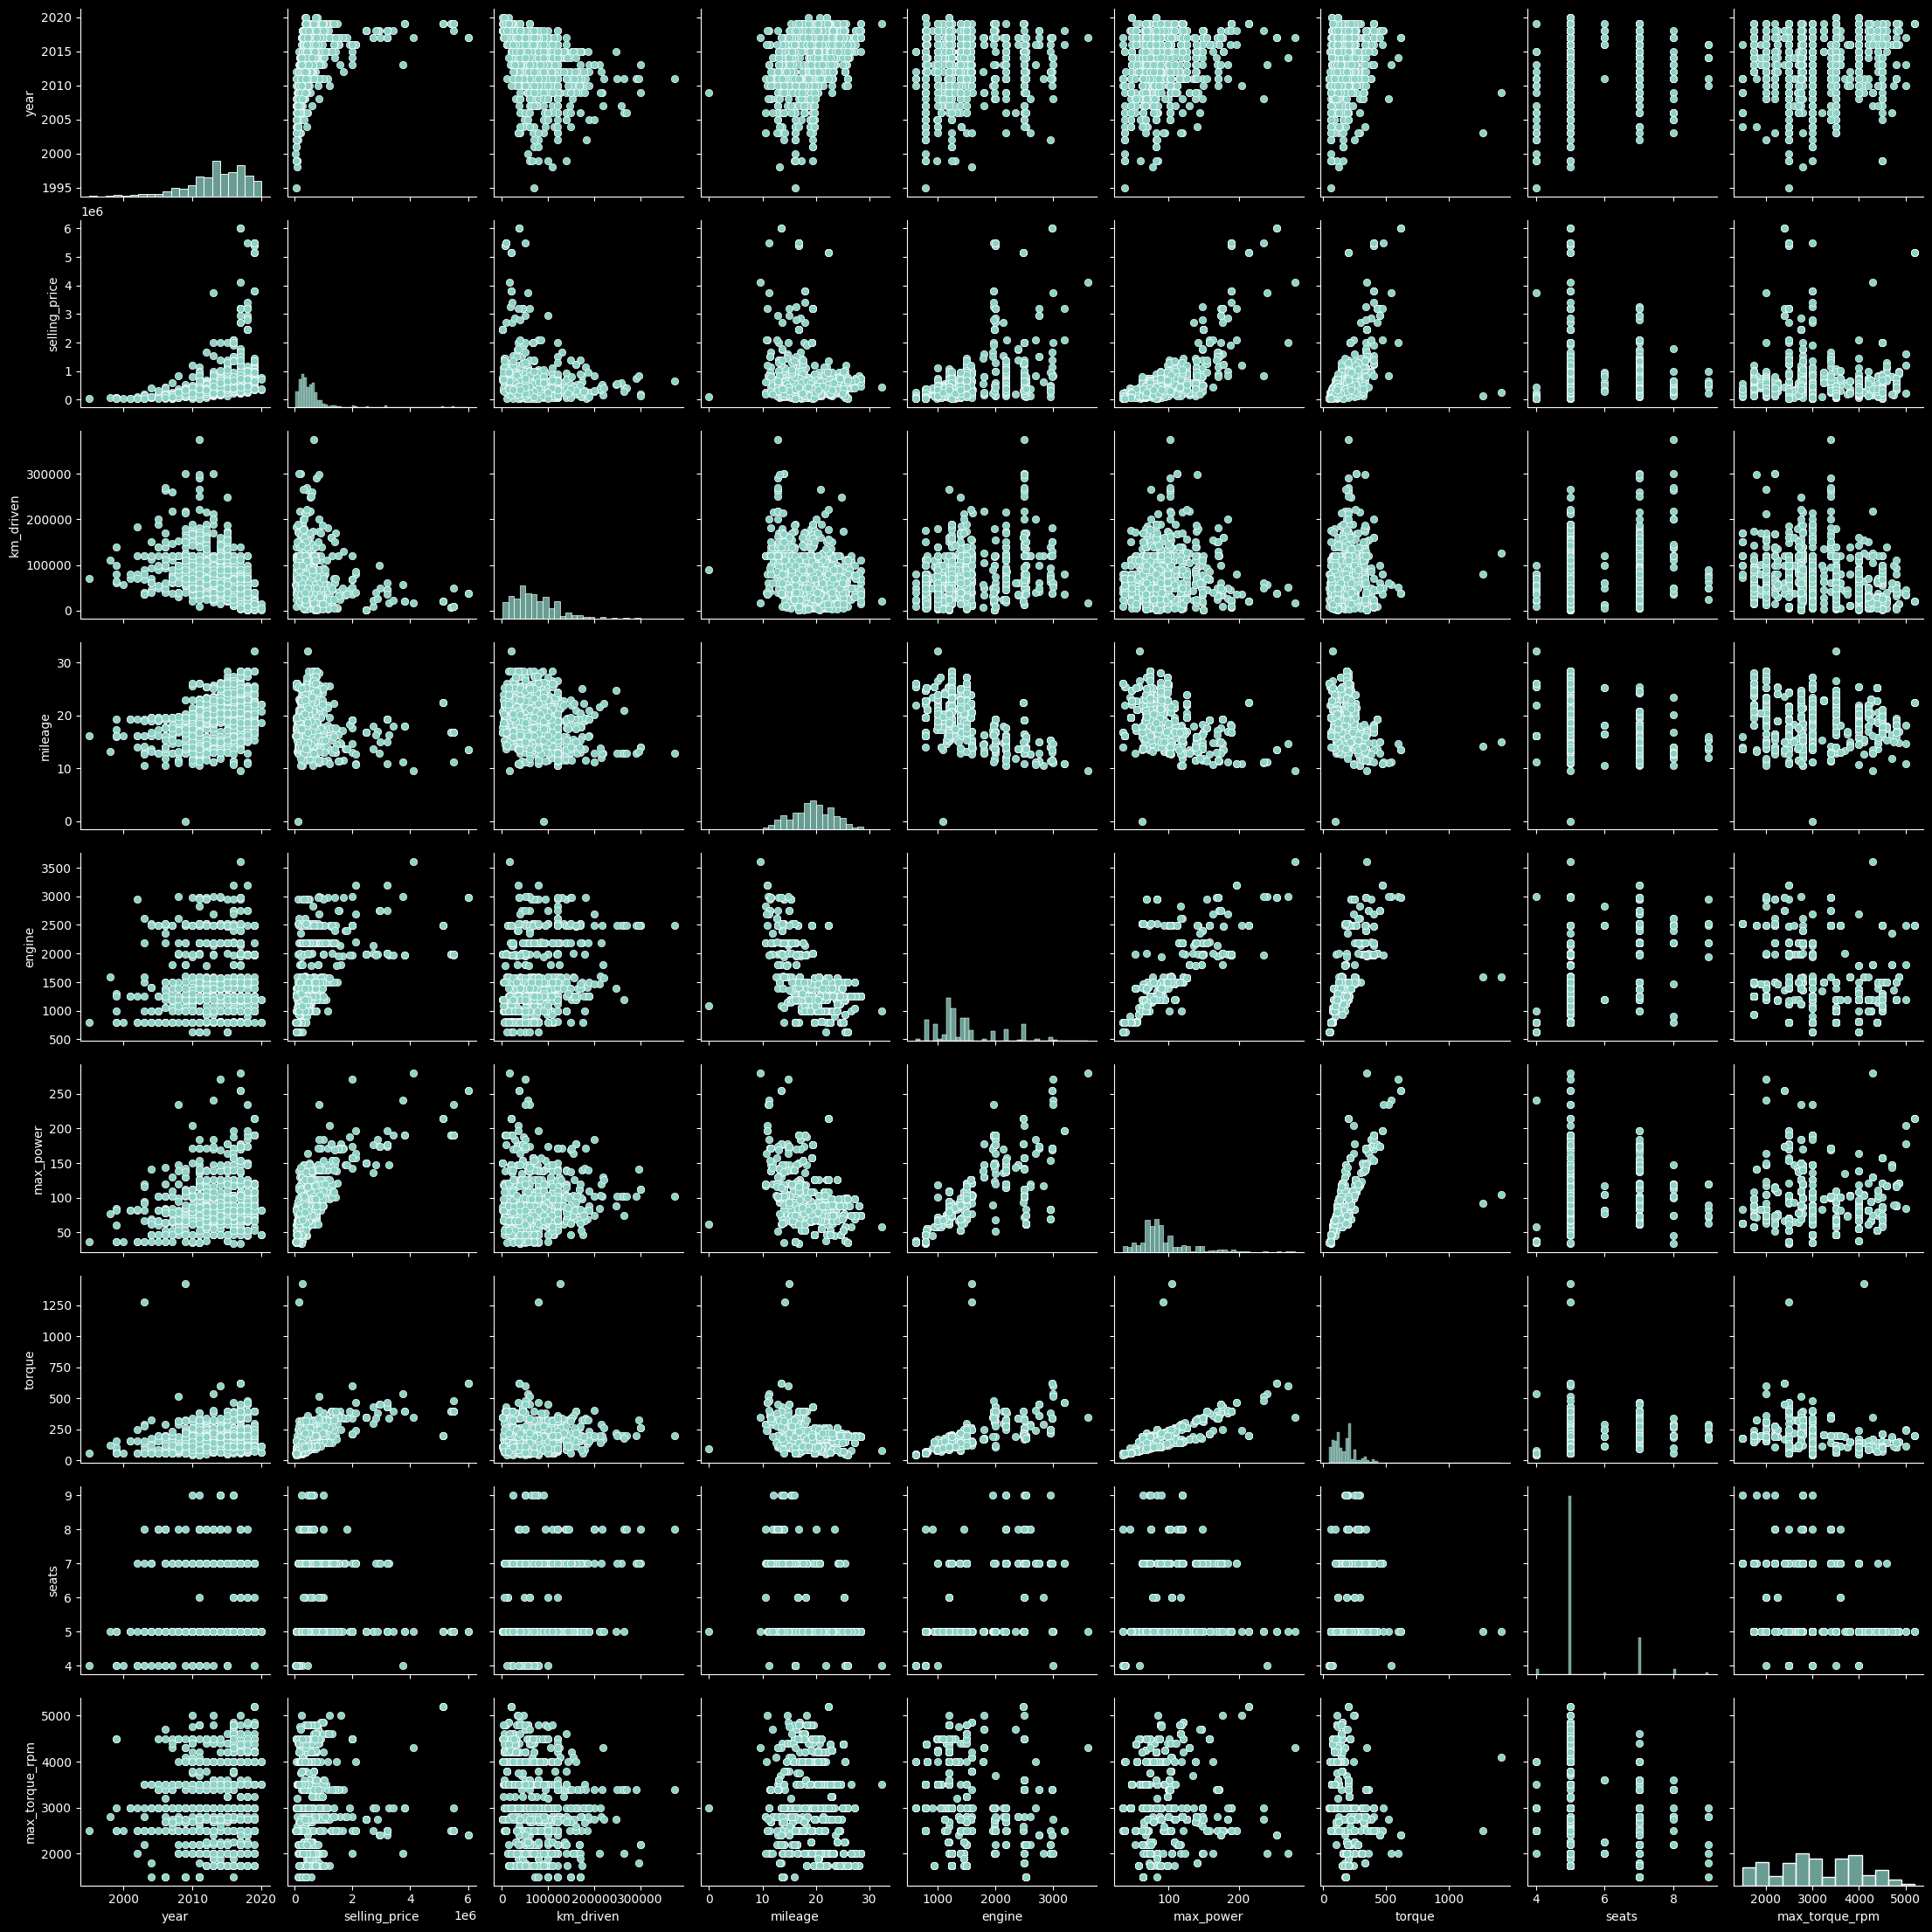

In [38]:
sns.pairplot(df_test[num_cols]);

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
"Похожими ли оказались совокупности при разделении на трейн и тест?" - Да. В некоторых случаях есть выбросы и облако точек выглядет кучнее, как например с max_torque_rpm, но направление зависимости одинаковое.
</div>

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

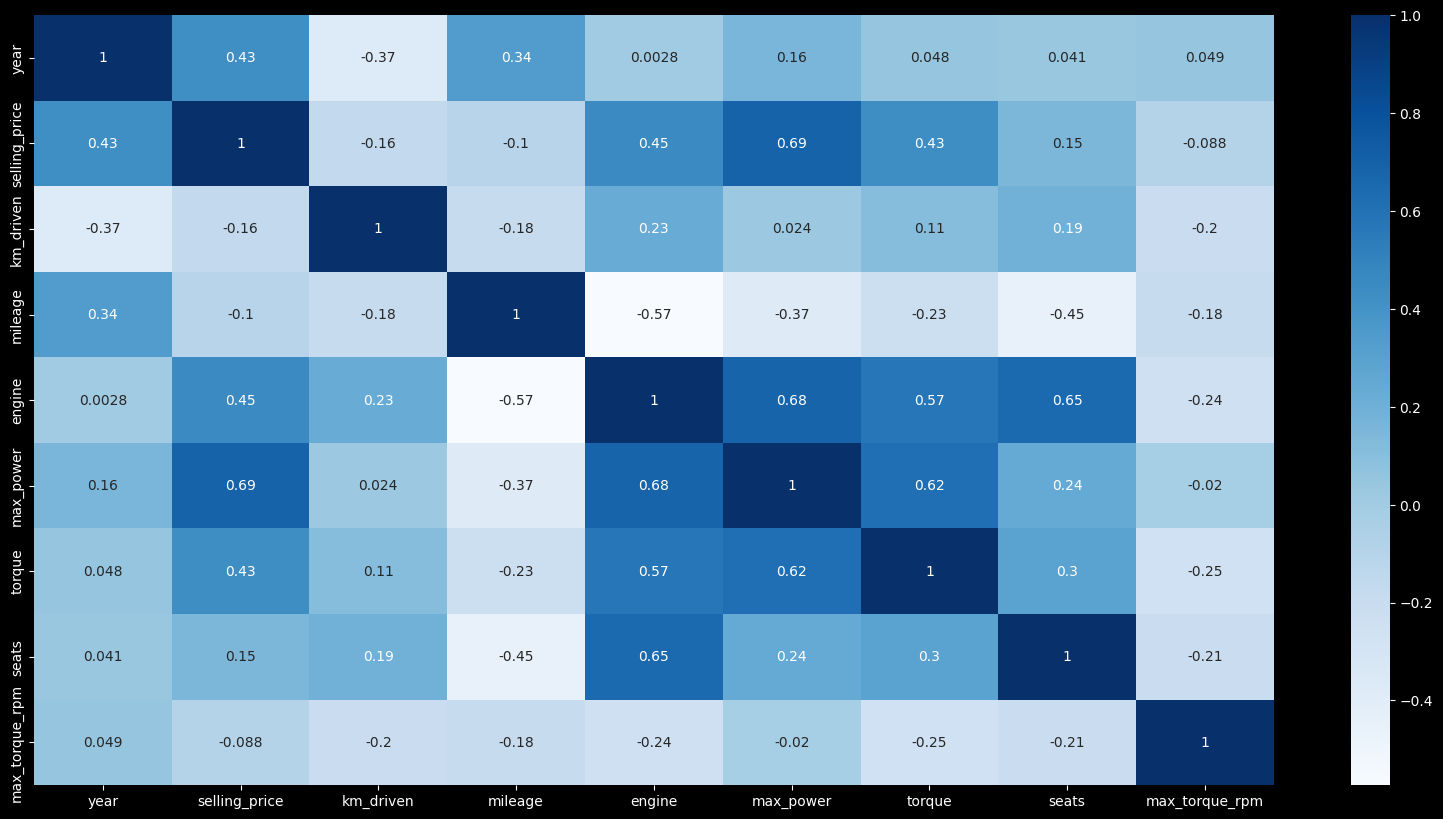

In [39]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(df_train[num_cols].corr(), cmap='Blues', annot=True);

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Самая слабая корреляция между `max_torque_rpm` и `max_power`.

Самая сильная зависимость наблюдается между `max_power` и `selling_price`.

Да. Между годом выпуска и киллометражем наблюдается не сильная обратная зависимость.

Мы использовали по умолчанию корреляцию Пирсона, но параметор `method` принимает также значения `kendall` и `spearman`.
</div>

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [40]:
def compute_ranks(data: np.array) -> np.array:
    sorted_indices = np.argsort(data)
    ranks = np.zeros(len(data))

    current_rank = 1
    for i in sorted_indices:
        ranks[i] = current_rank
        current_rank += 1

    unique_values, counts = np.unique(data, return_counts=True)

    for value, count in zip(unique_values, counts):
        if count > 1:
            indices = np.where(data == value)[0]
            mean_rank = np.mean(ranks[indices])
            ranks[indices] = mean_rank

    return ranks

def spearman_correlation(X: np.array, Y: np.array) -> float:
    n = len(X)

    if len(np.unique(X)) == 1 or len(np.unique(Y)) == 1:
        return 0.0

    ranks_X = compute_ranks(X)
    ranks_Y = compute_ranks(Y)

    d = ranks_X - ranks_Y
    sum_d_squared = np.sum(d ** 2)

    if len(np.unique(ranks_X)) == n and len(np.unique(ranks_Y)) == n:
        correlation = 1 - (6 * sum_d_squared) / (n * (n**2 - 1))
    else:
        mean_rank_X = np.mean(ranks_X)
        mean_rank_Y = np.mean(ranks_Y)

        covariance = np.sum((ranks_X - mean_rank_X) * (ranks_Y - mean_rank_Y))
        std_X = np.sqrt(np.sum((ranks_X - mean_rank_X) ** 2))
        std_Y = np.sqrt(np.sum((ranks_Y - mean_rank_Y) ** 2))
        correlation = covariance / (std_X * std_Y)

    return correlation

def spearman_correlation_matrix(df: pd.DataFrame) -> pd.DataFrame:
    dataset = np.array(df)
    n_features = dataset.shape[1]
    correlation_matrix = np.ones((n_features, n_features))

    for i in range(n_features):
        for j in range(i + 1, n_features):
            corr = spearman_correlation(dataset[:, i], dataset[:, j])
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr
    result_df = pd.DataFrame(correlation_matrix, index=df.columns, columns=df.columns)
    return result_df

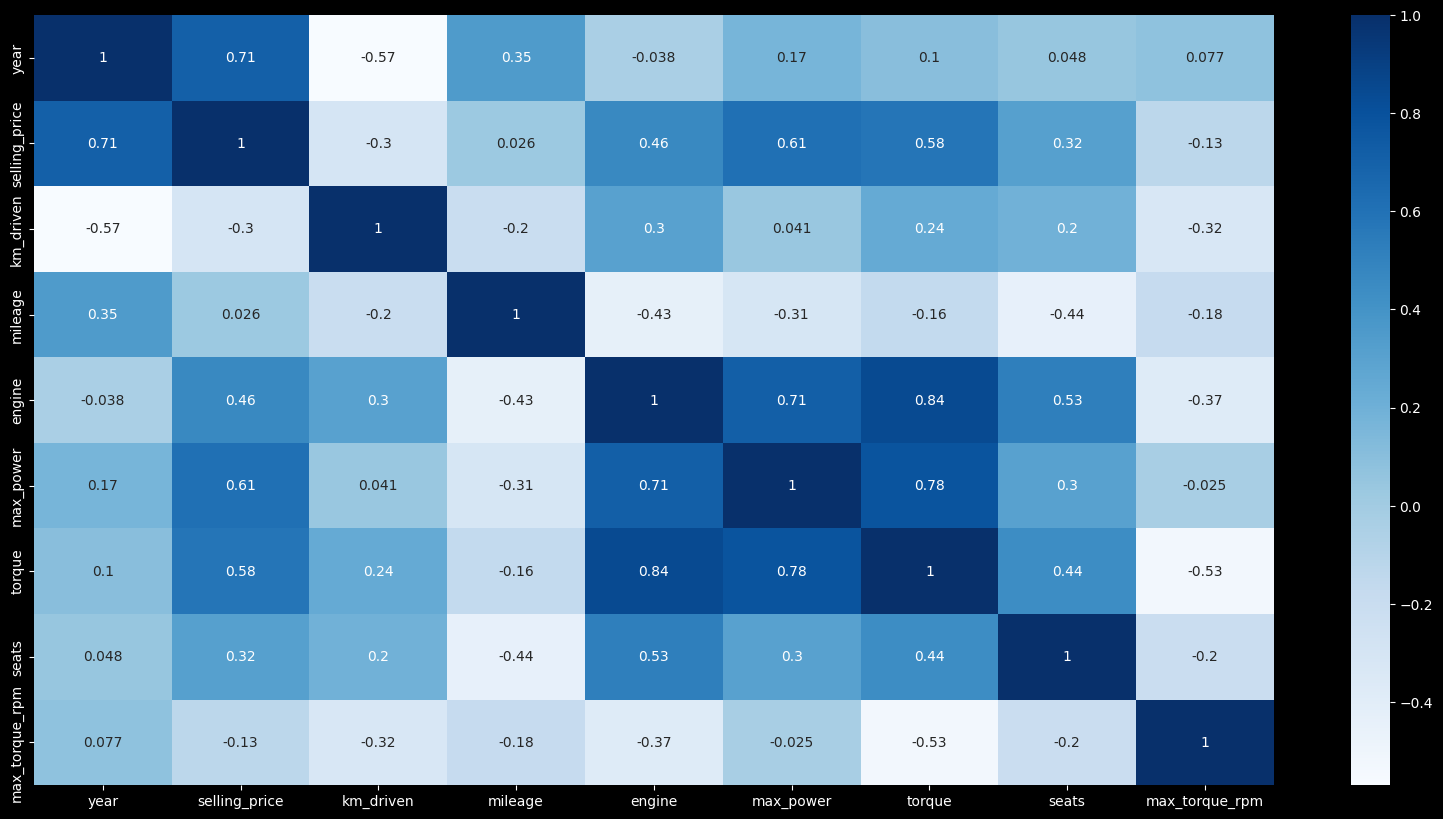

In [41]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(spearman_correlation_matrix(df_train[num_cols]), cmap='Blues', annot=True);

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
По корреляции Спирмена видна сильная прямая зависимость между годом и целевой переменной. Также сильно коррелируют между собой `engine`, `max_power` и `torque`.

Ниже представлена библиотечная реализация для сравнения.
</div>

In [42]:
df_train[num_cols].corr(method='spearman')

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.707123,-0.569659,0.346132,-0.038056,0.166267,0.102603,0.048291,0.076801
selling_price,0.707123,1.000000,-0.295665,0.026186,0.463577,0.612600,0.582414,0.317605,-0.126948
km_driven,-0.569659,-0.295665,1.000000,-0.198466,0.304504,0.040655,0.242934,0.195317,-0.321022
mileage,0.346132,0.026186,-0.198466,1.000000,-0.429871,-0.308239,-0.162381,-0.435458,-0.177191
engine,-0.038056,0.463577,0.304504,-0.429871,1.000000,0.713435,0.842430,0.527716,-0.372690
max_power,0.166267,0.612600,0.040655,-0.308239,0.713435,1.000000,0.779424,0.304095,-0.024834
torque,0.102603,0.582414,0.242934,-0.162381,0.842430,0.779424,1.000000,0.438233,-0.526370
seats,0.048291,0.317605,0.195317,-0.435458,0.527716,0.304095,0.438233,1.000000,-0.201905
max_torque_rpm,0.076801,-0.126948,-0.321022,-0.177191,-0.372690,-0.024834,-0.526370,-0.201905,1.000000


interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


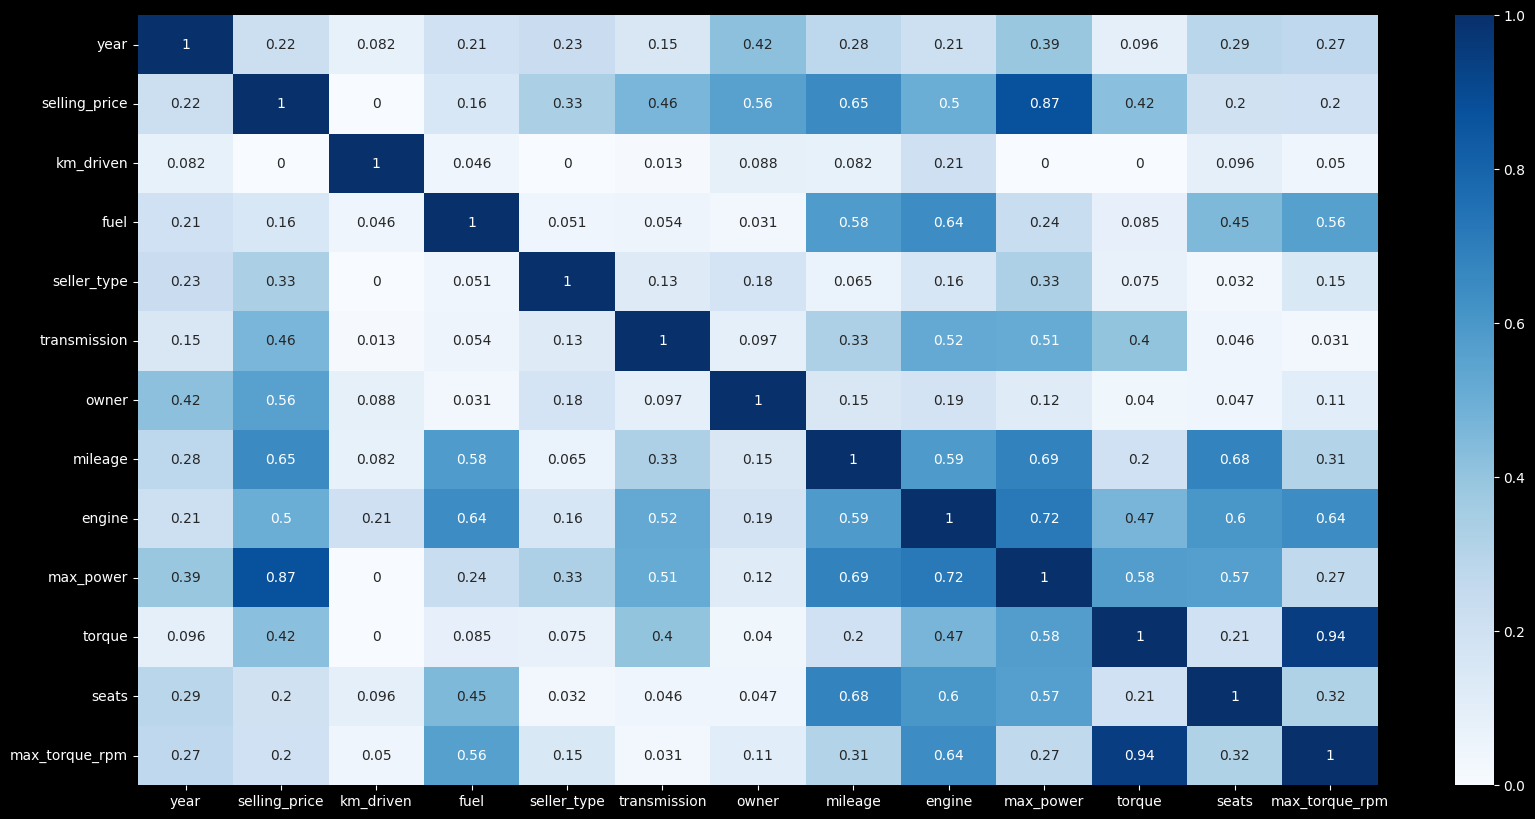

In [43]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(phik_matrix(df_train.drop('name', axis=1)), cmap='Blues', annot=True);

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Здесь мы видим еще более ярковы выраженную зависимость между `max_power` и `selling_price`. Появилась сильная корреляция между `torque` и `max_torque_rpm`, которой не было на предыдущем графике.
</div>

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Для наглядности зависимости цены от категориальных признков построим столбчатые диаграммы, а для понимания баланса значений внутри категориального признака построим круговые. Также добавим боксплот графики для числовых признаков для анализа выбросов.
</div>

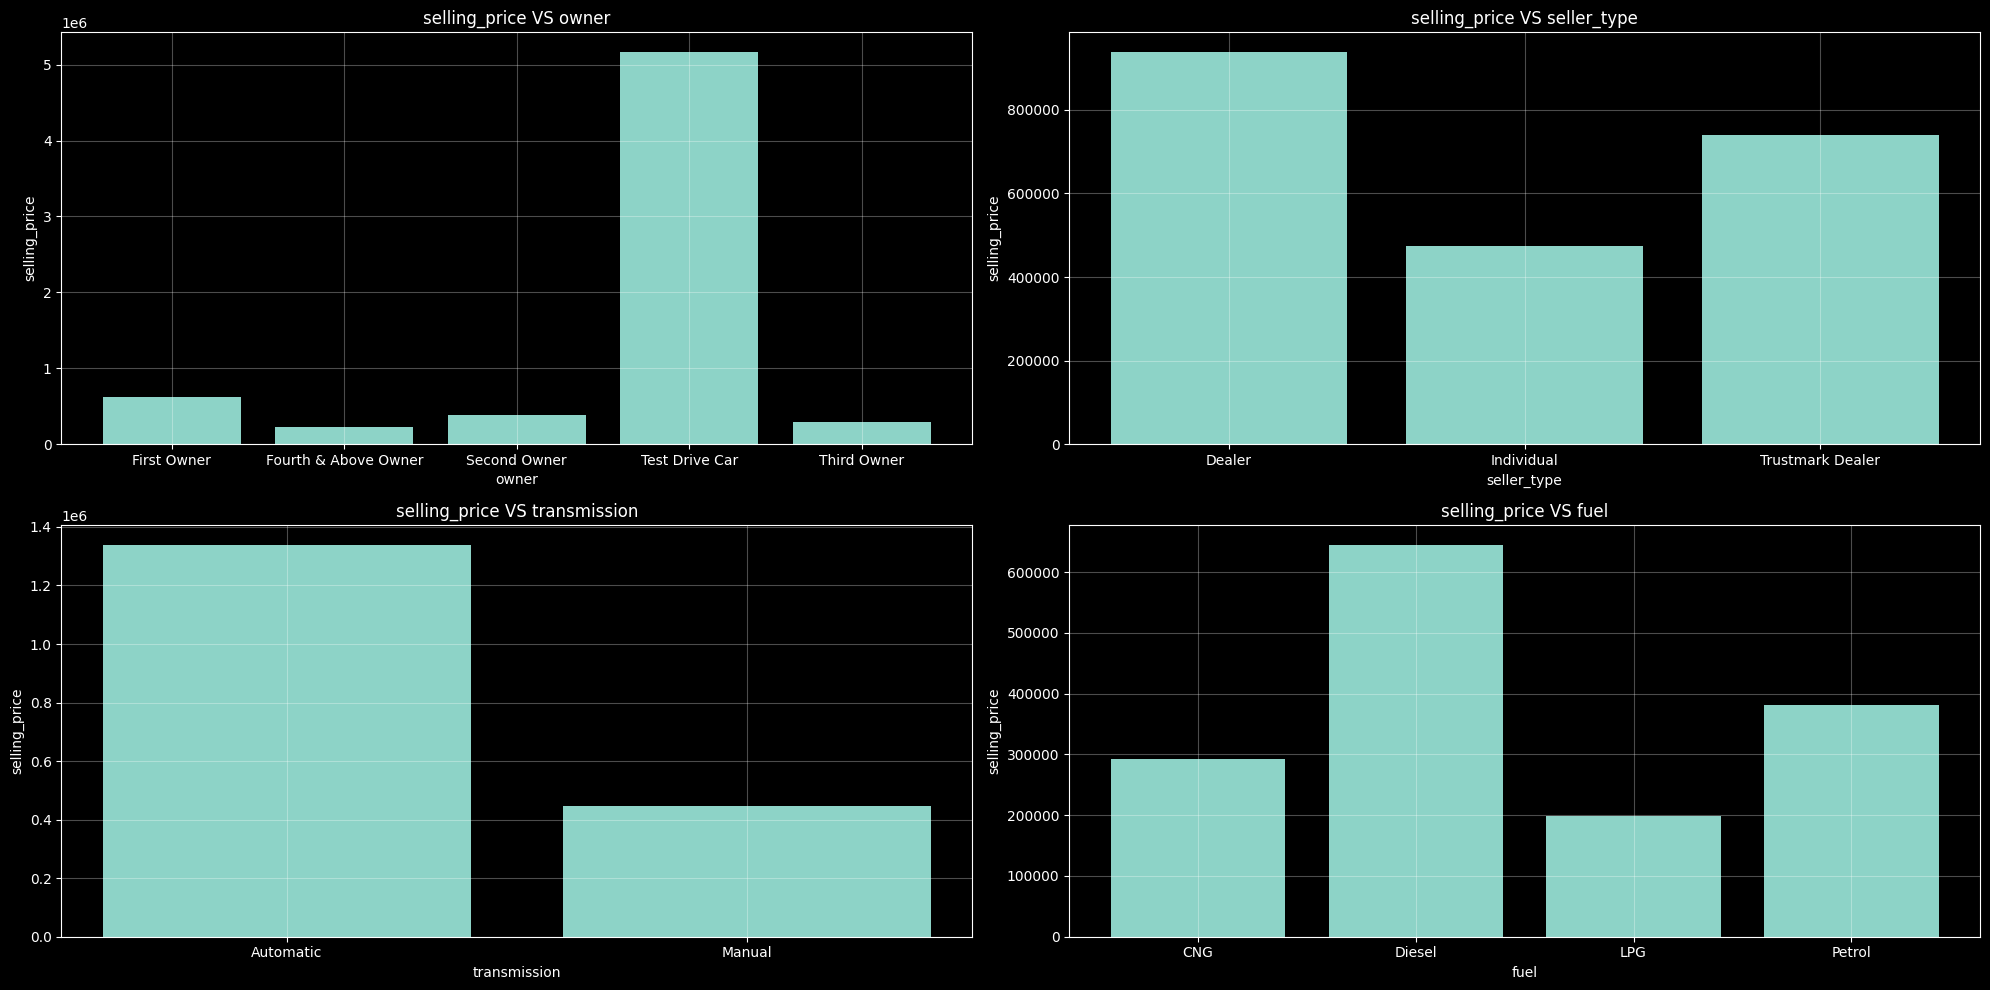

In [44]:
categorical_features = ['owner', 'seller_type', 'transmission', 'fuel']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    grouped_df = df_train.groupby(feature)['selling_price'].mean().reset_index()
    x = grouped_df[feature]
    y = grouped_df['selling_price']
    axes[i].bar(x, y)
    axes[i].grid(alpha=0.3)
    axes[i].set_title(f'selling_price VS {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('selling_price')

plt.tight_layout()
plt.show()

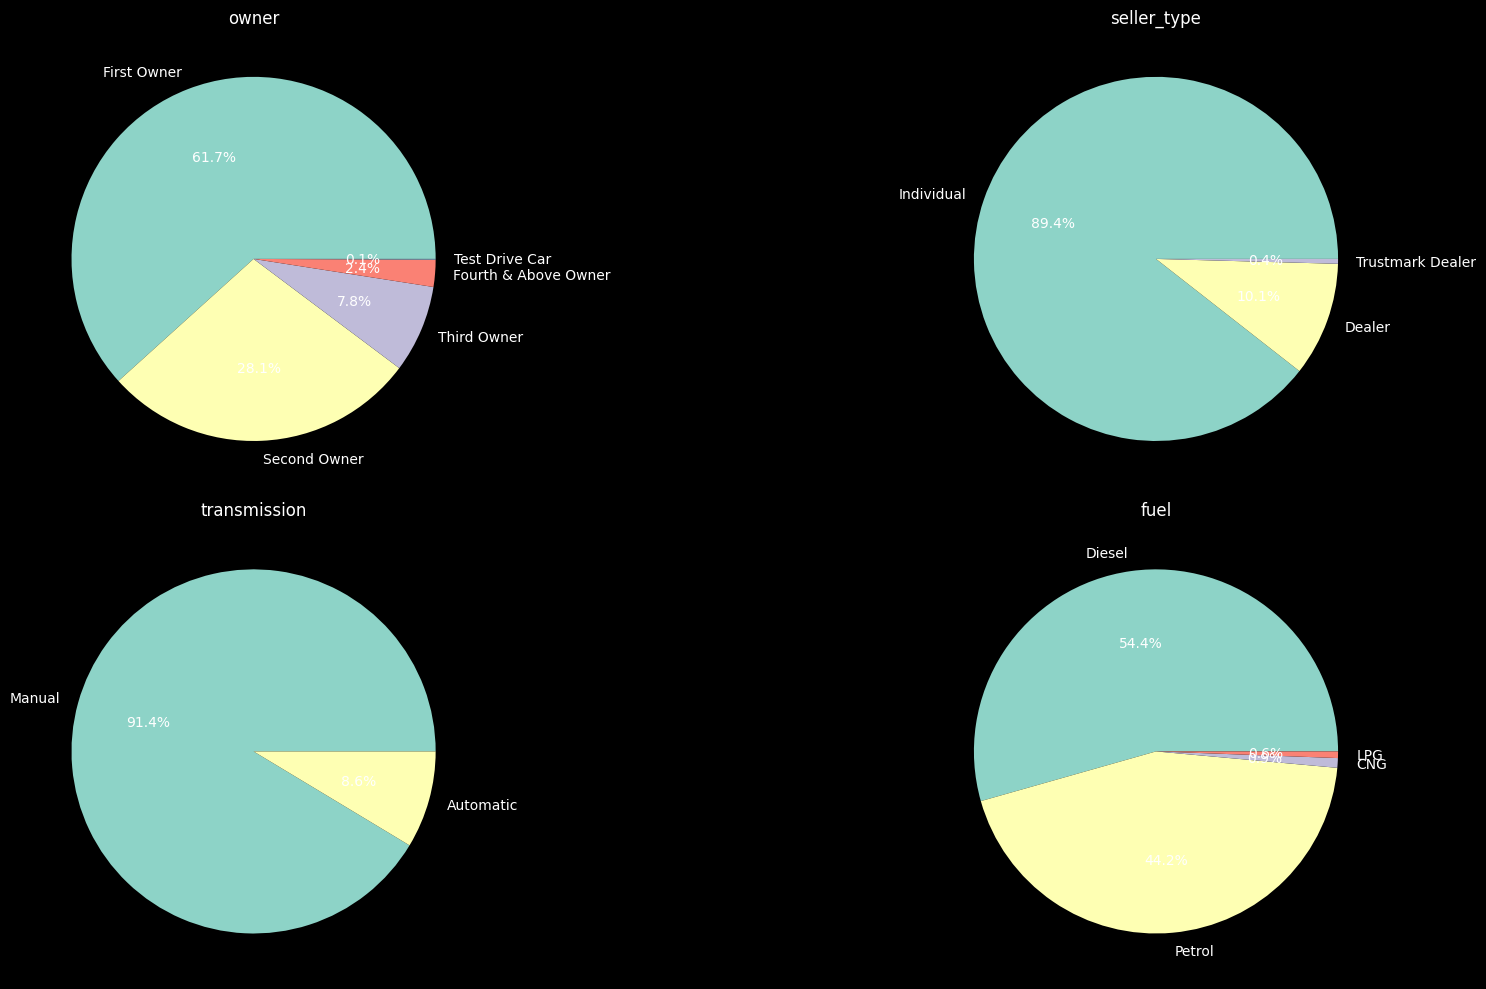

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    df_train[feature].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', ylabel='', title=feature, ax=axes[i])

plt.tight_layout()
plt.show()

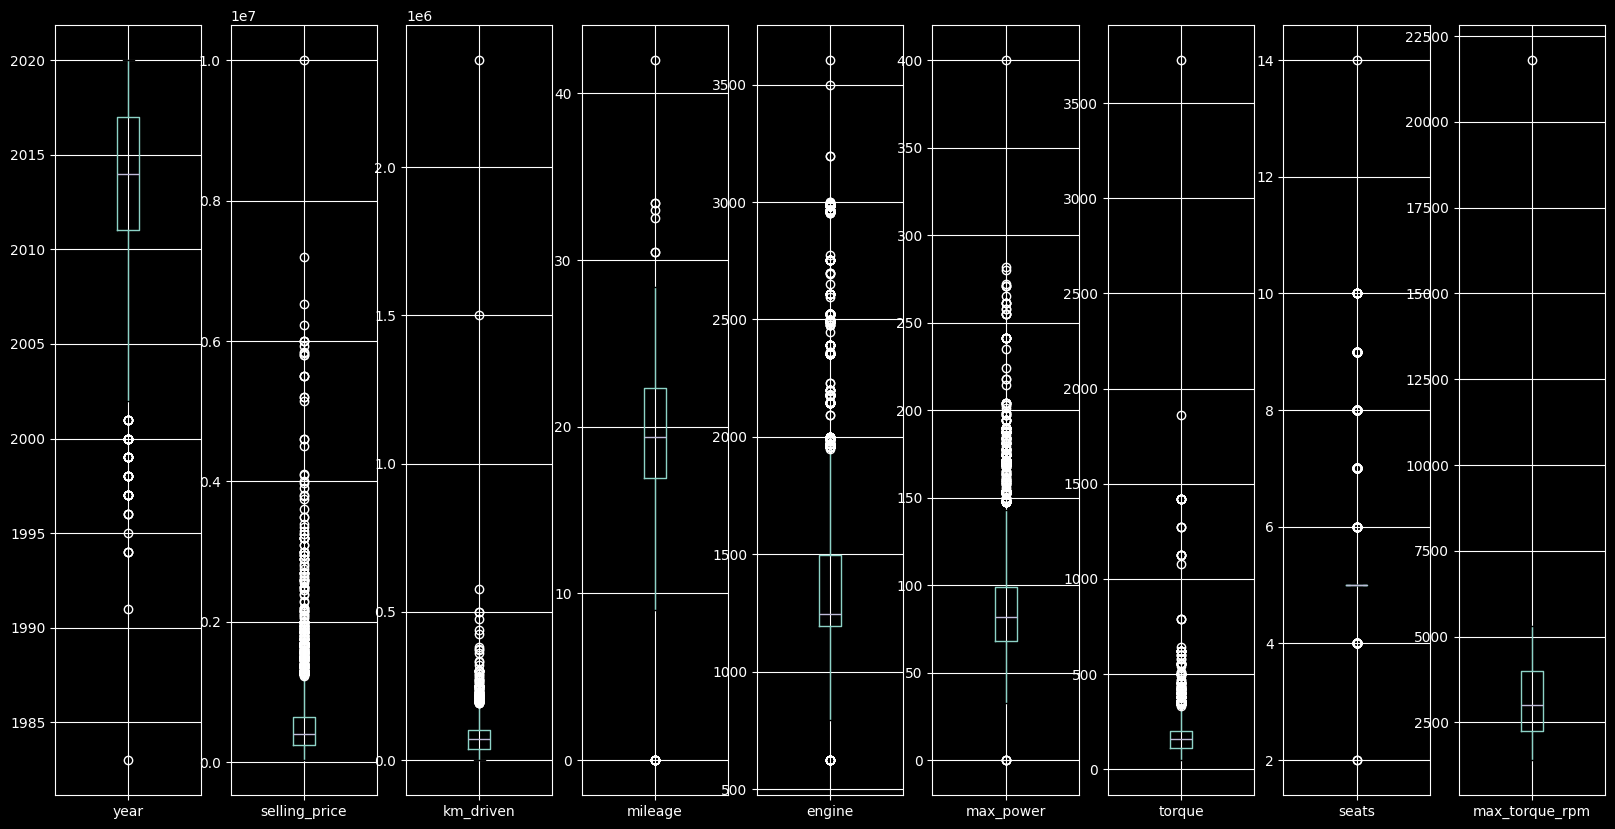

In [46]:
numerical_features = df_train.select_dtypes(np.number).columns
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    df_train.boxplot(column=feature, ax=axes[i]);

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Распределения средней цены от категориальных факторов не выглядет аномально. Авто с меньшим количеством владельцев, на автомате, на дизиле и у дилера стоят дороже, чем в других категориях каждого признака.

В категориальных признаках есть дисбаланс, ноне критичный.

В числовых признаках наблюдаются выбросы. В дальнейшем можно будет от них избавиться для улучшения качества модели.
</div>

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   int64  
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   int64  
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(4), int64(5), object(5)
memory usage: 638.9+ KB


In [48]:
drop_col = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
df_train_num = df_train.drop(drop_col, axis=1)
df_test_num = df_test.drop(drop_col, axis=1)

In [49]:
y_train = df_train_num['selling_price']
X_train = df_train_num.drop('selling_price', axis=1)

In [50]:
X_train.shape

(5840, 8)

In [51]:
assert X_train.shape == (5840, 8)

In [52]:
y_test = df_test_num['selling_price']
X_test = df_test_num.drop('selling_price', axis=1)

In [53]:
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

stage = []
r2 = []
mse = []

stage.append('base_line')
r2.append(r2_score(y_test, y_pred))
mse.append(MSE(y_test, y_pred))

r2_score(y_test, y_pred), MSE(y_test, y_pred)

(0.6000121467136995, 229924439977.48608)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Метрика `R2`=0.6 не самый худший вариант, но еще есть куда расти.
</div>

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">

**R² Score**

$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$

где:
- $y_i$ — истинное значение целевой переменной для $i$-го наблюдения
- $\hat{y}_i$ — предсказанное значение для $i$-го наблюдения
- $\bar{y}$ — среднее значение целевой переменной
- $n$ — количество наблюдений

</div>

In [55]:
def handmade_r2_score(y_test: np.array, y_pred: np.array) -> float:
  if len(y_test) == len(y_pred):
      return 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
  else:
      raise print("Массивы должны быть одного размера")

In [56]:
handmade_r2_score(y_test, y_pred)

np.float64(0.6000121467136995)

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [57]:
def handmade_adjusted_r2_score(y_test: np.array, y_pred: np.array, df_test: pd.DataFrame) -> float:
  if len(y_test) == len(y_pred) and len(y_test) == len(df_test):
    n = len(y_test)
    p = len(df_train.columns)
    return 1 - (1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)) * (n - 1) / (n - p - 1)
  else:
    raise print("Массивы должны быть одного размера")

In [58]:
handmade_adjusted_r2_score(y_test, y_pred, df_test)

np.float64(0.391459761860928)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
adjusted R2 чувствительна к количеству признаков в модели. Используется для сравнения моделей с разным количеством признаков.
</div>

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred2 = lr.predict(X_test_scaled)

stage.append('scaled_linear')
r2.append(r2_score(y_test, y_pred2))
mse.append(MSE(y_test, y_pred2))

r2_score(y_test, y_pred2), MSE(y_test, y_pred2)

(0.6000121467136992, 229924439977.48627)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Значение R2 никак не изменилось.
</div>

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [61]:
pd.DataFrame({'Feature': X_test.columns, 'Coef': lr.coef_}).sort_values('Coef', ascending=False)

,Feature,Coef
4,max_power,330477.517024
0,year,165099.181937
3,engine,22171.159010
5,torque,5087.296350
2,mileage,-8592.758874
6,seats,-29444.179939
1,km_driven,-49093.181646
7,max_torque_rpm,-59544.840497


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
`max_power` оказался наиболее информативным в предсказании цены.
</div>

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [62]:
lasso = Lasso(random_state=RANDOM_STATE)
lasso.fit(X_train_scaled, y_train)
y_pred3 = lasso.predict(X_test_scaled)

stage.append('scaled_lasso')
r2.append(r2_score(y_test, y_pred3))
mse.append(MSE(y_test, y_pred3))

r2_score(y_test, y_pred3), MSE(y_test, y_pred3)

(0.6000108594580604, 229925179928.78586)

In [63]:
pd.DataFrame({'Feature': X_test.columns, 'Coef': lasso.coef_}).sort_values('Coef', ascending=False)

,Feature,Coef
4,max_power,330478.904797
0,year,165096.982384
3,engine,22169.132935
5,torque,5086.660183
2,mileage,-8589.480401
6,seats,-29440.191852
1,km_driven,-49092.238007
7,max_torque_rpm,-59542.751251


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Модель не занулила никакие веса, что говорит о значимости каждого признака в предсказании целевой переменной, либо надо корректно подобрать гиперпараметры модели.

</div>

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [64]:
lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'max_iter': [1000, 2000, 5000],
    'selection': ['cyclic', 'random']
}

lasso = Lasso(random_state=RANDOM_STATE)
lasso_grid = GridSearchCV(
    lasso,
    lasso_param_grid,
    cv=10,
    scoring='r2',
)

lasso_grid.fit(X_train_scaled, y_train)

,estimator,Lasso(random_state=42)
,param_grid,"{'alpha': [0.1, 1.0, ...], 'max_iter': [1000, 2000, ...], 'selection': ['cyclic', 'random']}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10000.0


In [65]:
y_pred4 = lasso_grid.predict(X_test_scaled)

stage.append('scaled_lasso_grid')
r2.append(r2_score(y_test, y_pred4))
mse.append(MSE(y_test, y_pred4))

r2_score(y_test, y_pred4), MSE(y_test, y_pred4)

(0.5864563101221313, 237716721945.88803)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Грид-сёрчу пришлось обучать 360 моделей.

Параметры в lasso_param_grid:

`alpha` - параметр регуляризации. Контролирует силу штрафа за большие коэффициенты.

`max_iter` - максимальное количество итераций алгоритма оптимизации.

`selection` - стратегия обновления коэффициентов во время оптимизации. `Cyclic` обновляет коэффициенты по порядку, `random` - в случайном порядке.

</div>

In [66]:
lasso_grid.best_params_

{'alpha': 10000.0, 'max_iter': 1000, 'selection': 'random'}

In [67]:
pd.DataFrame({'Feature': X_test.columns, 'Coef': lasso_grid.best_estimator_.coef_}).sort_values('Coef', ascending=False)

,Feature,Coef
4,max_power,336659.920071
0,year,153234.943246
2,mileage,0.000000
3,engine,0.000000
5,torque,0.000000
6,seats,-0.000000
1,km_driven,-39296.944418
7,max_torque_rpm,-45909.122815


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Лучший коэффициент регуляризации получился `alpha`=10000, при нем занулился признак `engine`, `mileage`, `seats`, `torque`.

</div>

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [68]:
elastic_net_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_iter': [1000, 2000, 5000]
}

elastic_net = ElasticNet(random_state=RANDOM_STATE)
elastic_net_grid = GridSearchCV(
    elastic_net,
    elastic_net_param_grid,
    cv=10,
    scoring='r2'
)

elastic_net_grid.fit(X_train_scaled, y_train)

,estimator,ElasticNet(random_state=42)
,param_grid,"{'alpha': [0.001, 0.01, ...], 'l1_ratio': [0.1, 0.3, ...], 'max_iter': [1000, 2000, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1.0


In [69]:
elastic_net_grid.best_params_

{'alpha': 1.0, 'l1_ratio': 0.9, 'max_iter': 1000}

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Грид-сёрчу пришлось обучать 900 моделей.

Лучшие гиперпараметры модели: `{'alpha': 1.0, 'l1_ratio': 0.9, 'max_iter': 1000}`
</div>

In [70]:
pd.DataFrame({'Feature': X_test.columns, 'Coef': elastic_net_grid.best_estimator_.coef_}).sort_values('Coef', ascending=False)

,Feature,Coef
4,max_power,273866.811971
0,year,153433.429518
3,engine,53582.392773
5,torque,26963.696166
2,mileage,-850.387140
6,seats,-31610.564300
7,max_torque_rpm,-42198.465227
1,km_driven,-51086.191499


In [71]:
y_pred5 = elastic_net_grid.predict(X_test_scaled)

stage.append('scaled_elastic_net_grid')
r2.append(r2_score(y_test, y_pred5))
mse.append(MSE(y_test, y_pred5))

r2_score(y_test, y_pred5), MSE(y_test, y_pred5)

(0.5768890247054557, 243216270803.33643)

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [72]:
class L0LinearRegression:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.model = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        best_loss = np.inf
        best_features = []

        for i in range(1, n_features + 1):
            for selected_features in itertools.combinations(range(n_features), i):
                X_subset = X[:, selected_features]
                model_subset = LinearRegression()
                model_subset.fit(X_subset, y)
                mse = MSE(y, model_subset.predict(X_subset))
                order = 10 ** (len(str(int(mse))) - 2) # чтобы не подбирать огромную лямбду
                total_loss = mse + self.alpha * len(selected_features) * order

                if total_loss < best_loss:
                    best_loss = total_loss
                    best_features = selected_features
                    best_model = model_subset

        self.selected_features_ = list(best_features)
        self.model = best_model

        self.coef_ = np.zeros(n_features)
        if len(self.selected_features_) > 0:
            self.coef_[self.selected_features_] = self.model.coef_

        self.intercept_ = self.model.intercept_
        return self

    def predict(self, X):
        X = np.array(X)
        if self.model is None:
            raise ValueError("Модель еще не обучена")
        X_selected = X[:, self.selected_features_]
        return self.model.predict(X_selected)

In [73]:
l0 = L0LinearRegression(alpha=0.1)
l0.fit(X_train_scaled, y_train)
y_pred6 = l0.predict(X_test_scaled)

In [74]:
r2_l0_list = []
mse_l0_list = []
zero_coefs = []


alpha_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for alpha in alpha_list:
    l0 = L0LinearRegression(alpha=alpha)
    l0.fit(X_train_scaled, y_train)
    y_pred6 = l0.predict(X_test_scaled)

    r2_l0_list.append(r2_score(y_test, y_pred6))
    mse_l0_list.append(MSE(y_test, y_pred6))
    zero_coefs.append(sum(l0.coef_ == 0))

In [75]:
l0_results = pd.DataFrame({'Alpha': alpha_list, 'Zero_coefs': zero_coefs, 'R2': r2_l0_list, 'MSE': mse_l0_list})
l0_results

,Alpha,Zero_coefs,R2,MSE
0,0.001,0,0.600012,2.299244e+11
1,0.010,2,0.599943,2.299644e+11
2,0.100,4,0.596115,2.321645e+11
3,1.000,6,0.580990,2.408587e+11
4,10.000,7,0.512615,2.801629e+11
5,100.000,7,0.512615,2.801629e+11


In [76]:
l0 = L0LinearRegression(alpha=0.1)
l0.fit(X_train_scaled, y_train)
y_pred6 = l0.predict(X_test_scaled)

In [77]:
pd.DataFrame({'Feature': X_test.columns, 'Coef': l0.coef_}).sort_values('Coef', ascending=False)

,Feature,Coef
4,max_power,345880.239234
0,year,158374.560045
2,mileage,0.000000
3,engine,0.000000
5,torque,0.000000
6,seats,0.000000
1,km_driven,-50134.926069
7,max_torque_rpm,-58190.513071


In [78]:
stage.append('scaled_L0LinearRegression')
r2.append(r2_score(y_test, y_pred6))
mse.append(MSE(y_test, y_pred6))

r2_score(y_test, y_pred6), MSE(y_test, y_pred6)

(0.5961152567171357, 232164483625.6928)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Был написан класс L0LinearRegression с использованием L0 регуляризации, которая штрафует модель за ненулевые веса признаков.
Было проведено 6 экспериментов с разными коэффициентами регуляризации, результаты сохранены в датафрейм `l0_results`, по которым видно, что при увеличении `alpha`увеличивается количество нулевых весов, но при этом падает качество модели. Для оптимального результата была выбрана модель с `alpha`=0.1, которая зануляет половину признаков, но при этом сохраняет на уровне качество модели.
</div>

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [79]:
X_train_cat = df_train.drop('selling_price', axis=1)
X_test_cat = df_test.drop('selling_price', axis=1)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Оставим только марку авто для сокращения категорий в признаке.
</div>

In [80]:
X_train_cat['name'] = X_train_cat['name'].apply(lambda x: x.split()[0])
X_test_cat['name'] = X_test_cat['name'].apply(lambda x: x.split()[0])

In [81]:
assert X_train_cat.shape == (5840, 13)

In [82]:
X_train_cat.describe(include='object')

,name,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840,5840
unique,30,4,3,2,5
top,Maruti,Diesel,Individual,Manual,First Owner
freq,1804,3177,5223,5336,3603


In [83]:
X_train_cat['name'].unique()

array(['Maruti', 'Skoda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Honda', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Isuzu', 'Peugeot'], dtype=object)

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [84]:
cat_cols = X_train_cat.select_dtypes(include='object').columns.tolist() + ['seats']
num_cols = [col for col in X_train_cat.columns if col not in cat_cols]

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
Для корректной работы с OHE необходимо удалять один из закодированных столбцов, чтобы не вызвать мультиколлинеарности в данных при добавлении столбцы с единицами для интерсепта.

Удалять столбцы, которые оказались "не важными" не рекомендуется, т.к. есть вероятность, что на целевую переменную влияет не конкретный столбец, а совокупность признаков и в случае удаления, мы можем потерять в качестве.
</div>

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [85]:
pipeline = Pipeline([
        ('preprocessing', ColumnTransformer([
            ('numeric_scaling', StandardScaler(), num_cols),
            ('categorical_encoding', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
        ])),
        ('model', Ridge(random_state=RANDOM_STATE))
    ])

In [86]:
ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

ridge_grid = GridSearchCV(
    pipeline,
    ridge_param_grid,
    cv=10,
    scoring='r2'
)

ridge_grid.fit(X_train_cat, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__alpha': [0.001, 0.01, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric_scaling', ...), ('categorical_encoding', ...)]"


In [87]:
ridge_grid.best_params_

{'model__alpha': 1.0}

In [88]:
y_pred7 = ridge_grid.predict(X_test_cat)

stage.append('scaled+cat_ridge_grid')
r2.append(r2_score(y_test, y_pred7))
mse.append(MSE(y_test, y_pred7))

r2_score(y_test, y_pred7), MSE(y_test, y_pred7)

(0.7827155776876732, 124901290640.52861)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Качество модели удалось улучшить. R2=0.7827
</div>

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [89]:
df_train = df_train[df_train['km_driven'].between(100,1000000)]
df_train = df_train[df_train['max_power'] != 0]
df_train = df_train[df_train['max_torque_rpm'].between(1000, 10000)]

In [90]:
def feature_engineering(df):
    df['engine * max_power'] = df['engine'] * df['max_power']
    df['year sq'] = df['year'] ** 2
    df['mod_torque'] = np.log(df['torque'])
    df['gas'] = df['fuel'].apply(lambda x: 1 if x in ['CNG', 'LPG'] else 0)
    df['model'] = df['name'].apply(lambda x: x.split()[1])
    df['name'] = df['name'].apply(lambda x: x.split()[0])

    return df

drop_cols = ['selling_price']
X_train_cat = df_train.drop(drop_cols, axis=1)
X_test_cat = df_test.drop(drop_cols, axis=1)

y_train = df_train['selling_price']
y_test = df_test['selling_price']

cat_cols = X_train_cat.select_dtypes(include='object').columns.tolist() + ['seats', 'model']
num_cols = [col for col in X_train_cat.columns if col not in cat_cols] + ['engine * max_power', 'year sq', 'mod_torque']

feature_engineering_transformer = FunctionTransformer(feature_engineering)

fe_pipeline = Pipeline([
    ('feature_engineering', feature_engineering_transformer),
    ('preprocessor', ColumnTransformer([
        ('num_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat_pipeline', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='NDT')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_cols)
    ], remainder='passthrough')),
    ('model', Ridge(random_state=RANDOM_STATE))
])

ridge_param_grid = {
    'preprocessor__num_pipeline__imputer__strategy': ['median', 'mean'],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

fe_ridge_grid = GridSearchCV(
    fe_pipeline,
    ridge_param_grid,
    cv=10,
    scoring='r2'
)

fe_ridge_grid.fit(X_train_cat, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__alpha': [0.001, 0.01, ...], 'preprocessor__num_pipeline__imputer__strategy': ['median', 'mean']}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,func,<function fea...t 0x11e4f2660>


In [91]:
fe_ridge_grid.best_params_

{'model__alpha': 0.001,
 'preprocessor__num_pipeline__imputer__strategy': 'median'}

In [92]:
y_pred8 = fe_ridge_grid.predict(X_test_cat)

stage.append('feature_engineering_ridge_grid')
r2.append(r2_score(y_test, y_pred8))
mse.append(MSE(y_test, y_pred8))

r2_score(y_test, y_pred8), MSE(y_test, y_pred8)

(0.9275768050991519, 41630920519.576065)

In [93]:
MODEL_NAME = 'feature_engineering_ridge_grid.pkl'
with open(MODEL_NAME, 'wb') as file:
    pickle.dump(fe_ridge_grid, file)

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Был проведен раяд экспериментов. Ниже представлены результаты.

Сработало:
- Возведение в квадрат `year`.
- Умножение `engine` и `max_power`.
- Взятие логарифма из `torque`.
- Добавление флага `gas` на основе `fuel`.
- Избавление от выбросов в тренировочной выборке в признаках `km_driven`, `max_power`, `max_torque_rpm`.
- Добавление колонки с моделью авто `model`.


Не сработало:
- Возведение во всякие разные степени `km_driven`.
- Возведение в логарифм `km_driven`.
- Дробление `km_driven` на партиции и кодирование как категориальный признак.
- Добавление флага `Dealer` на основе признака `seller_type`.
- Заполнение пропусков средним значением.
</div>

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [94]:
def business_metrics(y_true, y_pred):
    mape = abs(y_true - y_pred) / y_true
    return sum(mape <= 0.1) / len(mape)

bus_metrics = []
bus_metrics.append(business_metrics(y_test, y_pred))
bus_metrics.append(business_metrics(y_test, y_pred2))
bus_metrics.append(business_metrics(y_test, y_pred3))
bus_metrics.append(business_metrics(y_test, y_pred4))
bus_metrics.append(business_metrics(y_test, y_pred5))
bus_metrics.append(business_metrics(y_test, y_pred6))
bus_metrics.append(business_metrics(y_test, y_pred7))
bus_metrics.append(business_metrics(y_test, y_pred8))

<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Данная метрика в первую очередь отвечает на вопрос какая доля прогнозов является практически полезной для бизнеса, т.к. сильное отклонение цены как в минус, так и в плюс влечет за собой снижение продаж и убытки.
</div>

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
Для каждого бизнеса важно отслеживать не только прибыль, но и убыток. Напишем метрику, которая будет считать долю прогнозов, где модель предсказала цену более чем на 20% ниже реальной.
</div>

In [95]:
def loss_business_metrics(y_true, y_pred):
    neg_mape = (y_true - y_pred) / y_true
    return sum(neg_mape > 0.2) / len(neg_mape)

loss_bus_metrics = []
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred2))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred3))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred4))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred5))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred6))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred7))
loss_bus_metrics.append(loss_business_metrics(y_test, y_pred8))

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

In [96]:
results_df = pd.DataFrame(
    {
        'Этап': stage,
        'R2': r2,
        'MSE': mse,
        'bus_metric': bus_metrics,
        'loss_business_metric': loss_bus_metrics
        }
    )
results_df

,Этап,R2,MSE,bus_metric,loss_business_metric
0,base_line,0.600012,2.299244e+11,0.243,0.266
1,scaled_linear,0.600012,2.299244e+11,0.243,0.266
2,scaled_lasso,0.600011,2.299252e+11,0.243,0.266
3,scaled_lasso_grid,0.586456,2.377167e+11,0.241,0.256
4,scaled_elastic_net_grid,0.576889,2.432163e+11,0.256,0.242
5,scaled_L0LinearRegression,0.596115,2.321645e+11,0.248,0.261
6,scaled+cat_ridge_grid,0.782716,1.249013e+11,0.303,0.218
7,feature_engineering_ridge_grid,0.927577,4.163092e+10,0.355,0.193


<div style="background-color: lightblue; padding: 10px; border-radius: 5px; color: black;">
    
<strong>Общий вывод:</strong>
1. Был проведен разведовательный анализ тренировочной и тестовой выборки.
    - Были обнаружены явные и не явные дубликаты. В тренировчной выборке от явных дубликатов избавились по средствам оставления первого входящего значения в выборку.
    - Были обнаружены пропуски, которые заполнили медианой.
    - Построили графики `pairplot` для визуального определения зависимостей между признаками, а также сравнения распределения признаков в тренировочной и тестовой выборке. При анализе было выявлено, что распределения в обоих выборках похожи, а также наблюдается нелинейная зависимость между некоторыми признаками.
    - Была посчитана коррелция Пирсона и Спирмена. Выявлена зависимость между следующими признаками:
          - самая сильная зависимость наблюдается между `max_power` и `selling_price` по корреляции Пирсона,
          - сильно коррелируют между собой `engine`, `max_power` и `torque` по корреляции Спирмена.
    - Построили матрицу корреляций из библиотеки `phik`. Обнаружили еще более ярковы выраженную зависимость между `max_power` и `selling_price`. Появилась сильная корреляция между `torque` и `max_torque_rpm`.
    - Дополнительно были построены графики распределения средней цены авто от категориальных факторов. Авто с меньшим количеством владельцев, на автомате, на дизиле и у дилера стоят дороже, чем в других категориях каждого признака.
    - По круговой диаграмме категориальных признаков был выявлен не критичный дисбаланс.
    - По графику боксплот видны выбросы в числовых признаках.
2. Обучили модель линейной регрессии только на вещественных признаках, получили качество `R2`=0.6. Реализовали метрику `adjusted R2`, получили значение 0.39.
3. Стандартизировали признаки и заново провели обучение. Метрика не поменялась `R2`=0.6. Самым значимым признаком в обучении оказался `max_power`.
4. Обучили Lasso регрессию на дефолтных параметрах, получили такой же результат метрики `R2`=0.6.
5. Добавили GridSearchCV к Lasso регрессии с сеткой параметров
   `lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'max_iter': [1000, 2000, 5000],
    'selection': ['cyclic', 'random']}`
    метрика `R2` стала хуже.
6. Обучили GridSearchCV с ElasticNet регрессией с параметрами
   `elastic_net_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_iter': [1000, 2000, 5000]
    }`
   метрика `R2` стала еще хуже.
7. Написали класс L0LinearRegression и обучили с разным коэффициентом регуляризации. Эксперимент показал, что при увеличении `alpha` растет количество нулевых весов, но падает метрика `R2`. Была выбрана оптимальная медель с коэффициентом `alpha`=0.1, которая зануляет половину признаков, но при этом показывает метрику `R2`=0.596.
8. Добавлены категориальные признаки, которые были закодированы с помощью OneHotEncoder.
9. Написан pipeline с Ridge регрессией и подбором гиперпараметров с GridSearchCV по сетке
    `ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}`
   метрика стала лучше `R2`=0.78.
10. Проведен feature engineering:
    - Возведение в квадрат `year`.
    - Умножение `engine` и `max_power`.
    - Взятие логарифма из `torque`.
    - Добавление флага `gas` на основе `fuel`.
    - Добавление колонки с моделью авто `model`.

    Также были не успешные попытки:
    - Возведение во всякие разные степени `km_driven`.
    - Возведение в логарифм `km_driven`.
    - Дробление `km_driven` на партиции и кодирование как категориальный признак.
    - Добавление флага `Dealer` на основе признака `seller_type`.

    Также помогло избавление от выбросов в тренировочной выборке в признаках `km_driven`, `max_power`, `max_torque_rpm`.

    В итоге был построен pipeline Ridge регрессией и подбором гиперпараметров с GridSearchCV по сетке
    `ridge_param_grid = {
    'preprocessor__num_pipeline__imputer__strategy': ['median', 'mean'],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}`

    Получили наилучшую метрику `R2`=0.93
11. Были посчитаны бизнес метрики:
    - долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% `bus_metric`,
    - долю прогнозов, где модель предсказала цену более чем на 20% ниже реальной `loss_bus_metric`.

13. Результаты всех экспериметов сохранены в `results_df`.

| Этап                      | R2       | MSE          | bus_metric | loss_business_metric |
|---------------------------|----------|--------------|------------|---------------------|
| base_line                 | 0.600012 | 2.299244e+11 | 0.243      | 0.266              |
| scaled_linear             | 0.600012 | 2.299244e+11 | 0.243      | 0.266              |
| scaled_lasso              | 0.600011 | 2.299252e+11 | 0.243      | 0.266              |
| scaled_lasso_grid         | 0.586456 | 2.377167e+11 | 0.241      | 0.256              |
| scaled_elastic_net_grid   | 0.576889 | 2.432163e+11 | 0.256      | 0.242              |
| scaled_L0LinearRegression   | 0.596115 | 2.321645e+11 | 0.248      | 0.261              |
| scaled+cat_ridge_grid     | 0.782716 | 1.249013e+11 | 0.303      | 0.218              |
| feature_engineering_ridge_grid | 0.927577 | 4.163092e+10 | 0.355     | 0.193         |
</div>